In [ ]:
! pip install python-dotenv

In [ ]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle
import optuna
from xgboost import XGBClassifier

# Register API for Financial Modeling Prep (Financial Statements and Company Fundamentals)
# https://site.financialmodelingprep.com/developer/
# Register API for Federal Reserve Economic Data (For Macroeconomics Data)
# https://fred.stlouisfed.org/docs/api/fred/
# Yahoo Finance does not need an API

warnings.filterwarnings('ignore')

In [ ]:
# Load Data
dataset = pd.read_csv("Stock_data.csv")

# Null value analysis
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4790 entries, 0 to 4789
Data columns (total 118 columns):
 #    Column                                                Dtype  
---   ------                                                -----  
 0    year                                                  int64  
 1    adjDividend                                           float64
 2    dps_growth                                            float64
 3    dps_growth_rate                                       float64
 4    industry                                              object 
 5    sector                                                object 
 6    interestRate                                          float64
 7    interestRate_percentage_change                        float64
 8    symbol                                                object 
 9    currentRatio                                          float64
 10   currentRatio_percentage_change                        float64
 11   qu

In [ ]:
dataset.isna().sum()

year                                         0
adjDividend                                  0
dps_growth                                   0
dps_growth_rate                              0
industry                                     0
                                            ..
enterpriseValueMultiple                      0
enterpriseValueMultiple_percentage_change    0
priceFairValue                               0
priceFairValue_percentage_change             0
dps_change_next_year                         0
Length: 118, dtype: int64

In [ ]:
df = dataset #create copy df before one hot encoding
enc = OrdinalEncoder()
df = dataset.copy()
df[["industry","sector", "symbol"]] = enc.fit_transform(df[["industry","sector", "symbol"]])
df.head()

,year,adjDividend,dps_growth,dps_growth_rate,industry,sector,interestRate,interestRate_percentage_change,symbol,currentRatio,...,priceEarningsToGrowthRatio_percentage_change,priceSalesRatio,priceSalesRatio_percentage_change,dividendYield,dividendYield_percentage_change,enterpriseValueMultiple,enterpriseValueMultiple_percentage_change,priceFairValue,priceFairValue_percentage_change,dps_change_next_year
0,2013,2.54,0.18,7.627119,23.0,7.0,0.11,-21.428571,297.0,1.698186,...,21.912892,2.590120,43.788017,0.021636,-28.717284,10.375463,41.488241,4.455070,49.198542,constant/increased
1,2014,3.42,0.88,34.645669,23.0,7.0,0.09,-18.181818,297.0,1.961487,...,-39.853265,2.802775,8.210229,0.024847,14.839742,11.018038,6.193217,6.786417,52.330210,constant/increased
2,2015,4.10,0.68,19.883041,23.0,7.0,0.13,44.444444,297.0,1.543411,...,709.657256,2.602706,-7.138241,0.032502,30.811804,10.475280,-4.926085,6.707612,-1.161218,constant/increased
3,2016,4.44,0.34,8.292683,23.0,7.0,0.40,207.692308,297.0,1.885512,...,-82.081834,2.998496,15.206860,0.029663,-8.736708,11.444603,9.253432,8.728774,30.132361,constant/increased
4,2017,4.70,0.26,5.855856,23.0,7.0,1.00,150.000000,297.0,1.857292,...,-512.145931,3.714250,23.870455,0.023839,-19.634183,13.720421,19.885518,10.117194,15.906239,constant/increased


In [ ]:
# Multivariate Analysis
#target = dataset["dps_change_next_year"]
df.drop("dps_change_next_year", axis="columns", inplace=True)
# Correlation matrix
correlation_matrix = df.corr()

def rank_columns_by_correlation(df, threshold=0.9):
    # Calculating correlation matrix
    corr_matrix = df.corr()
    # Initializing a list to hold the tuples (col1, col2, correlation)
    correlations = []
    # Iterating over the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):  # avoiding duplicate and self-correlation
            # Including only correlations above the specified threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlations.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    # Sorting the list by absolute correlation in descending order
    sorted_correlations = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)
    correlation_df = pd.DataFrame(sorted_correlations, columns=['Column1', 'Column2', 'Correlation'])
    return correlation_df

top_correlations = rank_columns_by_correlation(df, 0.98)

# Remove highly correlated columns
columns_to_remove = top_correlations["Column2"].unique()
dataset.drop(columns_to_remove, axis="columns", inplace=True)
print(columns_to_remove)

['operatingCycle' 'ebitPerRevenue' 'ebitPerRevenue_percentage_change'
 'cashFlowCoverageRatios' 'cashFlowCoverageRatios_percentage_change'
 'priceToBookRatio' 'priceFairValue' 'priceToBookRatio_percentage_change'
 'priceFairValue_percentage_change' 'priceSalesRatio'
 'priceSalesRatio_percentage_change' 'priceCashFlowRatio'
 'priceCashFlowRatio_percentage_change'
 'dividendPayoutRatio_percentage_change'
 'cashConversionCycle_percentage_change'
 'daysOfPayablesOutstanding_percentage_change' 'cashRatio'
 'dividendPayoutRatio' 'cashRatio_percentage_change'
 'totalDebtToCapitalization_percentage_change'
 'quickRatio_percentage_change' 'cashConversionCycle'
 'operatingCashFlowSalesRatio_percentage_change'
 'returnOnCapitalEmployed_percentage_change'
 'priceBookValueRatio_percentage_change']


In [ ]:
# Data Preprocessing
# Missing value
dataset.info(verbose=True)
dataset.dropna(inplace=True)
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4790 entries, 0 to 4789
Data columns (total 93 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   year                                                  4790 non-null   int64  
 1   adjDividend                                           4790 non-null   float64
 2   dps_growth                                            4790 non-null   float64
 3   dps_growth_rate                                       4790 non-null   float64
 4   industry                                              4790 non-null   object 
 5   sector                                                4790 non-null   object 
 6   interestRate                                          4790 non-null   float64
 7   interestRate_percentage_change                        4790 non-null   float64
 8   symbol                                                4790

,year,adjDividend,dps_growth,dps_growth_rate,industry,sector,interestRate,interestRate_percentage_change,symbol,currentRatio,...,priceToFreeCashFlowsRatio_percentage_change,priceToOperatingCashFlowsRatio,priceToOperatingCashFlowsRatio_percentage_change,priceEarningsToGrowthRatio,priceEarningsToGrowthRatio_percentage_change,dividendYield,dividendYield_percentage_change,enterpriseValueMultiple,enterpriseValueMultiple_percentage_change,dps_change_next_year
0,2013,2.54,0.18,7.627119,Conglomerates,Industrials,0.11,-21.428571,MMM,1.698186,...,36.425366,13.745847,35.244905,2.554403,21.912892,0.021636,-28.717284,10.375463,41.488241,constant/increased
1,2014,3.42,0.88,34.645669,Conglomerates,Industrials,0.09,-18.181818,MMM,1.961487,...,-9.776946,13.460171,-2.078271,1.536390,-39.853265,0.024847,14.839742,11.018038,6.193217,constant/increased
2,2015,4.10,0.68,19.883041,Conglomerates,Industrials,0.13,44.444444,MMM,1.543411,...,-8.552877,12.273259,-8.817963,12.439492,709.657256,0.032502,30.811804,10.475280,-4.926085,constant/increased
3,2016,4.44,0.34,8.292683,Conglomerates,Industrials,0.40,207.692308,MMM,1.885512,...,8.393180,13.551743,10.416827,2.228929,-82.081834,0.029663,-8.736708,11.444603,9.253432,constant/increased
4,2017,4.70,0.26,5.855856,Conglomerates,Industrials,1.00,150.000000,MMM,1.857292,...,40.273886,18.843273,39.046864,-9.186440,-512.145931,0.023839,-19.634183,13.720421,19.885518,constant/increased


In [ ]:
# First let's leave out the last year's data as future test data, and 2021's data as validation data
training_data = dataset.loc[(dataset["year"] != 2022) & (dataset["year"] != 2021)]
validation_data = dataset.loc[dataset["year"] == 2021]
testing_data = dataset.loc[dataset["year"] == 2022]

# Predictor - Target Split
y_train = training_data["dps_change_next_year"]
X_train = training_data.drop("dps_change_next_year", axis="columns")
y_test = testing_data["dps_change_next_year"]
X_test = testing_data.drop("dps_change_next_year", axis="columns")
y_validate = validation_data["dps_change_next_year"]
X_validate = validation_data.drop("dps_change_next_year", axis="columns")

In [ ]:
# Label encode categorical features with many categories
categorical_columns = ["industry", "sector", "symbol"]
other_columns = [col for col in X_train.columns if col not in categorical_columns]

# Column Transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)
    ],
    remainder='passthrough'
)

In [ ]:
X_train_transformed = column_transformer.fit_transform(X_train)
X_validate_transformed = column_transformer.transform(X_validate)
X_test_transformed = column_transformer.transform(X_test)

# Note: after transformation, the output will be a numpy array and column orders will be changed.
X_train_transformed = pd.DataFrame(X_train_transformed, columns=categorical_columns + other_columns)
X_validate_transformed = pd.DataFrame(X_validate_transformed, columns=categorical_columns + other_columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=categorical_columns + other_columns)

# Check our data type
X_train_transformed.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 92 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   industry                                              3832 non-null   float64
 1   sector                                                3832 non-null   float64
 2   symbol                                                3832 non-null   float64
 3   year                                                  3832 non-null   float64
 4   adjDividend                                           3832 non-null   float64
 5   dps_growth                                            3832 non-null   float64
 6   dps_growth_rate                                       3832 non-null   float64
 7   interestRate                                          3832 non-null   float64
 8   interestRate_percentage_change                        3832

In [ ]:
# Let's change our data types back to their original forms - However, this time, categorical variables have become
# number like strings
cols_to_convert = {'industry': 'str', 'sector': 'str', 'symbol': 'str', 'year': 'int'}
X_train = X_train.astype(cols_to_convert)
X_validate = X_validate.astype(cols_to_convert)
X_test = X_test.astype(cols_to_convert)

In [ ]:
# Check data imbalance
# Let's add target back to our dataset for further analysis
training_data_transformed = pd.concat([X_train, y_train], axis=1)
training_data_transformed["dps_change_next_year"].value_counts()

dps_change_next_year
constant/increased    3618
decreased              214
Name: count, dtype: int64

In [ ]:
# Let's do some over sampling
# Perform oversampling using SMOTE
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_columns]
smote = SMOTENC(random_state=1, categorical_features=categorical_indices)

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_transformed, y_train)
# Check our training data
pd.DataFrame(y_train_oversampled)["dps_change_next_year"].value_counts()
X_train_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7236 entries, 0 to 7235
Data columns (total 92 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   industry                                              7236 non-null   float64
 1   sector                                                7236 non-null   float64
 2   symbol                                                7236 non-null   float64
 3   year                                                  7236 non-null   float64
 4   adjDividend                                           7236 non-null   float64
 5   dps_growth                                            7236 non-null   float64
 6   dps_growth_rate                                       7236 non-null   float64
 7   interestRate                                          7236 non-null   float64
 8   interestRate_percentage_change                        7236

feature 0's importance score: 0.005823150341968339 (industry)
feature 1's importance score: 0.01221246081244816 (sector)
feature 2's importance score: 0.0071975136970262536 (symbol)
feature 3's importance score: 0.0641358891110354 (year)
feature 4's importance score: 0.015662368798391287 (adjDividend)
feature 5's importance score: 0.14488383155960488 (dps_growth)
feature 6's importance score: 0.29403631096079386 (dps_growth_rate)
feature 7's importance score: 0.08214531771118302 (interestRate)
feature 8's importance score: 0.03775271718910484 (interestRate_percentage_change)
feature 9's importance score: 0.00247171002132544 (currentRatio)
feature 10's importance score: 0.0017772023785545751 (currentRatio_percentage_change)
feature 11's importance score: 0.003147585695005139 (quickRatio)
feature 12's importance score: 0.0033920029107241496 (daysOfSalesOutstanding)
feature 13's importance score: 0.0025911781276427397 (daysOfSalesOutstanding_percentage_change)
feature 14's importance scor

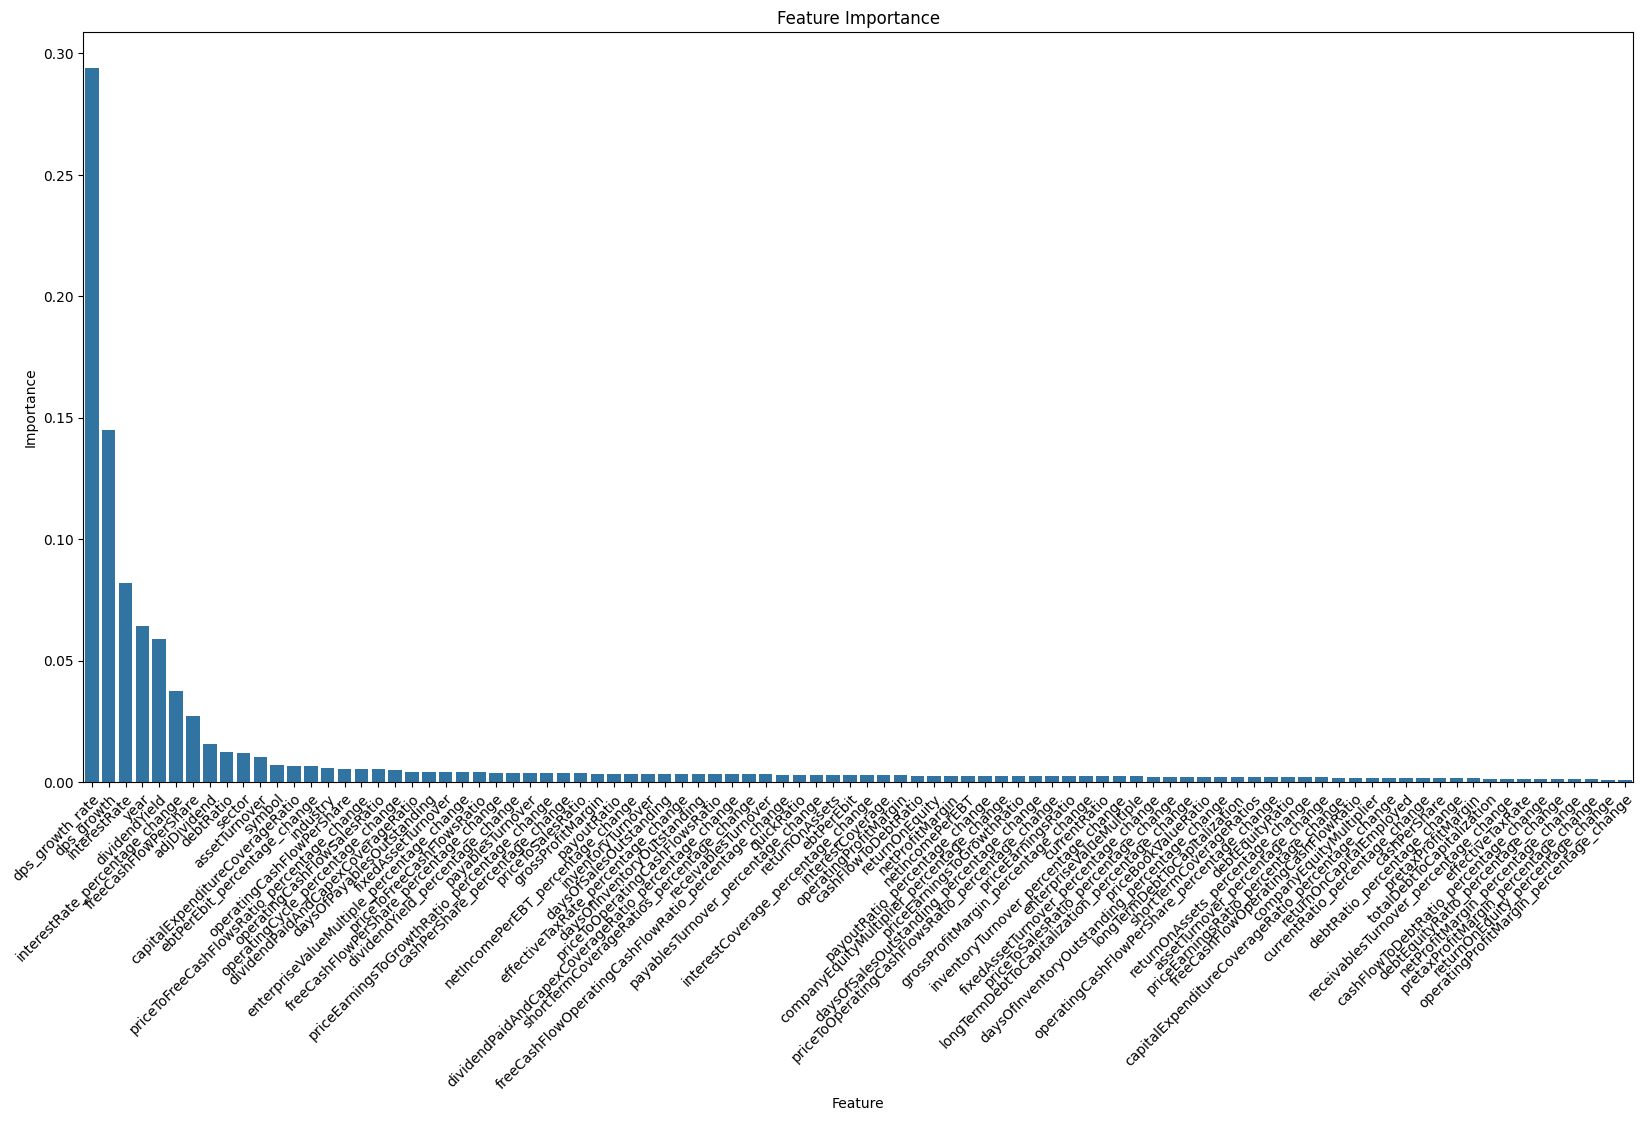

In [ ]:
# Feature selection

# Feature importance analysis - Tree Based
randomForestModel = RandomForestClassifier(max_features=None)  # We want all features to be considered for each tree
randomForestModel.fit(X_train_oversampled, y_train_oversampled)
model_importance = randomForestModel.feature_importances_
importance_table = pd.DataFrame(columns=["Feature", "Importance"])  # Create an importance table to plot bar chart
featureNum = 0
for score in model_importance:
    print("feature " + str(featureNum) + "'s importance score: " + str(score) + " (" + X_train_oversampled.columns[featureNum] + ")")
    rowAdded = pd.DataFrame([[X_train_oversampled.columns[featureNum], score]], columns=["Feature", "Importance"])
    importance_table = pd.concat([importance_table, rowAdded])
    featureNum = featureNum + 1
importance_table.sort_values('Importance', inplace=True, ascending=False)
# Plot a bar chart to visualize feature importance
plt.figure(figsize=(20, 10))
sns.barplot(data=importance_table, x="Feature", y="Importance")
plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.show()

In [ ]:
# Now let's remove the features one by one from the least important one
X_train_temp = X_train_oversampled.copy()
X_validate_temp = X_validate_transformed.copy()

# Initialize the result dataframe
result_df = pd.DataFrame(columns=['Features_Removed', 'ROC_Score'])

# First, evaluate performance using all features
randomForestModel = RandomForestClassifier(max_features=None)
randomForestModel.fit(X_train_temp, y_train_oversampled)
# Predict probabilities on test data
y_pred_probs = randomForestModel.predict_proba(X_validate_temp)[:, 1]
# Compute ROC score
roc_score = roc_auc_score(y_test, y_pred_probs)
# Append the result to the result dataframe
roc_dict = {'Features_Removed': 'None', 'ROC_Score': roc_score}
result_df = pd.DataFrame([roc_dict])
print(f"Feature_Removed: None, Number of features used: {len(X_train_temp.columns)}, ROC_AUC_Score: {roc_score}")

Feature_Removed: None, Number of features used: 92, ROC_AUC_Score: 0.6952380952380952


In [ ]:
# Sort importance_table by Importance in ascending order to start with the least important
importance_table_sorted = importance_table.sort_values('Importance')
# Loop through features, starting from the least important
for index, row in importance_table_sorted.iterrows():
    # Drop the feature from training and test data
    X_train_temp = X_train_temp.drop(columns=[row['Feature']])
    X_validate_temp = X_validate_temp.drop(columns=[row['Feature']])
    # Train a random forest model
    randomForestModel = RandomForestClassifier(max_features=None)
    randomForestModel.fit(X_train_temp, y_train_oversampled)
    # Predict probabilities on test data
    y_pred_probs = randomForestModel.predict_proba(X_validate_temp)[:, 1]
    # Compute ROC score
    roc_score = roc_auc_score(y_test, y_pred_probs)
    # Append the result to the result dataframe
    roc_dict = {'Features_Removed': row['Feature'], 'ROC_Score': roc_score}
    result_df = pd.DataFrame([roc_dict])
    print(
        f"Feature_Removed: {row['Feature']}, Number of features used: {len(X_train_temp.columns)}, ROC_AUC_Score: {roc_score}")
    # If only one feature left, break the loop
    if X_train_temp.shape[1] == 1:
        break

# Save the results
with open('result_df.pkl', 'wb') as file:
    pickle.dump(result_df, file)
with open('importance_table_sorted.pkl', 'wb') as file:
    pickle.dump(importance_table_sorted, file)

# Load the results
with open('result_df.pkl', 'rb') as file:
    result_df = pickle.load(file)

Feature_Removed: operatingProfitMargin_percentage_change, Number of features used: 91, ROC_AUC_Score: 0.7197802197802198
Feature_Removed: returnOnEquity_percentage_change, Number of features used: 90, ROC_AUC_Score: 0.7201923076923078
Feature_Removed: pretaxProfitMargin_percentage_change, Number of features used: 89, ROC_AUC_Score: 0.698489010989011
Feature_Removed: netProfitMargin_percentage_change, Number of features used: 88, ROC_AUC_Score: 0.6742673992673992
Feature_Removed: debtEquityRatio_percentage_change, Number of features used: 87, ROC_AUC_Score: 0.7084249084249086
Feature_Removed: cashFlowToDebtRatio_percentage_change, Number of features used: 86, ROC_AUC_Score: 0.7111263736263735
Feature_Removed: effectiveTaxRate, Number of features used: 85, ROC_AUC_Score: 0.7279761904761904
Feature_Removed: receivablesTurnover_percentage_change, Number of features used: 84, ROC_AUC_Score: 0.7410714285714286
Feature_Removed: totalDebtToCapitalization, Number of features used: 83, ROC_AUC_S

In [ ]:
# Model Selection

X_train_oversampled.info()
model_lr = LogisticRegression()
model_lr.fit(X_train_oversampled, y_train_oversampled)

# GridSearch
param_grid = {
    "penalty": ['l1', 'l2'],  # These have to be the same as the estimator's parameters' name
    "C": np.arange(0.1, 10, 0.1).tolist()
}
gridSearch = GridSearchCV(estimator=LogisticRegression(random_state=1), param_grid=param_grid, scoring='roc_auc',
                          cv=5, n_jobs=-1)
gridSearch.fit(X_train_oversampled, y_train_oversampled)

best_params_lr = gridSearch.best_params_
print("Best Parameters: ", best_params_lr)
print("Best ROC-AUC Score: ", gridSearch.best_score_)

# Create and save model
best_model_lr = LogisticRegression(**best_params_lr, solver='liblinear', n_jobs=-1)
with open('best_models_lr.pkl', 'wb') as file:
    pickle.dump(best_model_lr, file)


# Bayesian Optimization with optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress log messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7236 entries, 0 to 7235
Data columns (total 92 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   industry                                              7236 non-null   float64
 1   sector                                                7236 non-null   float64
 2   symbol                                                7236 non-null   float64
 3   year                                                  7236 non-null   float64
 4   adjDividend                                           7236 non-null   float64
 5   dps_growth                                            7236 non-null   float64
 6   dps_growth_rate                                       7236 non-null   float64
 7   interestRate                                          7236 non-null   float64
 8   interestRate_percentage_change                        7236

In [ ]:
# Logistic Regression
def objective_function(trial):
    C = trial.suggest_float('C', 0.1, 10, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver='liblinear',
        n_jobs=-1
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, C: {C}, penalty: {penalty}, ROC-AUC: {roc_auc}")
    return roc_auc


study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_function, n_trials=100)

best_params_lr = study_lr.best_params
print("Best Parameters: ", best_params_lr)
print("Best ROC-AUC Score: ", study_lr.best_value)

# Create and save model
best_model_lr = LogisticRegression(**best_params_lr, solver='liblinear', n_jobs=-1)
with open('best_models_lr.pkl', 'wb') as file:
    pickle.dump(best_model_lr, file)

Trial 0, C: 1.1298225126242838, penalty: l2, ROC-AUC: 0.49543050863829885
Trial 1, C: 1.297638167745642, penalty: l1, ROC-AUC: 0.740579653585676
Trial 2, C: 5.959944911494868, penalty: l2, ROC-AUC: 0.49543050863829885
Trial 3, C: 0.48771677127006724, penalty: l1, ROC-AUC: 0.7336360950296676
Trial 4, C: 1.4005064747472533, penalty: l1, ROC-AUC: 0.7382045420070071
Trial 5, C: 0.24090917376617874, penalty: l2, ROC-AUC: 0.49543050863829885
Trial 6, C: 2.3881902582885575, penalty: l1, ROC-AUC: 0.7399388633543333
Trial 7, C: 0.13995966890303518, penalty: l2, ROC-AUC: 0.49543050863829885
Trial 8, C: 1.236368262815582, penalty: l2, ROC-AUC: 0.49543050863829885
Trial 9, C: 5.6728389716123555, penalty: l1, ROC-AUC: 0.7404074045764111
Trial 10, C: 0.3625301044477393, penalty: l1, ROC-AUC: 0.7310456824802184
Trial 11, C: 9.817485971240304, penalty: l1, ROC-AUC: 0.7415018006474066
Trial 12, C: 9.714370293045198, penalty: l1, ROC-AUC: 0.7424838881943214
Trial 13, C: 9.167762671492882, penalty: l1, R

In [ ]:
# Decision Tree
def objective_function(trial):
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, "
          f"min_samples_leaf: {min_samples_leaf}, criterion: {criterion}, ROC-AUC: {roc_auc}")
    return roc_auc

study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_function, n_trials=100)

best_params_dt = study_dt.best_params
print("Best Parameters: ", best_params_dt)
print("Best ROC-AUC Score: ", study_dt.best_value)

# Create and save model
best_model_dt = DecisionTreeClassifier(**best_params_dt)
with open('best_models_dt.pkl', 'wb') as file:
    pickle.dump(best_model_dt, file)

Trial 0, max_depth: 47, min_samples_split: 2, min_samples_leaf: 2, criterion: gini, ROC-AUC: 0.8871781646999309
Trial 1, max_depth: 10, min_samples_split: 10, min_samples_leaf: 14, criterion: entropy, ROC-AUC: 0.9401051386855883
Trial 2, max_depth: 33, min_samples_split: 9, min_samples_leaf: 12, criterion: entropy, ROC-AUC: 0.9380433490120812
Trial 3, max_depth: 3, min_samples_split: 7, min_samples_leaf: 6, criterion: gini, ROC-AUC: 0.8179196793382207
Trial 4, max_depth: 47, min_samples_split: 9, min_samples_leaf: 9, criterion: entropy, ROC-AUC: 0.9318159863993397
Trial 5, max_depth: 48, min_samples_split: 15, min_samples_leaf: 13, criterion: entropy, ROC-AUC: 0.9352341561456685
Trial 6, max_depth: 32, min_samples_split: 7, min_samples_leaf: 5, criterion: gini, ROC-AUC: 0.898727733239895
Trial 7, max_depth: 15, min_samples_split: 2, min_samples_leaf: 5, criterion: entropy, ROC-AUC: 0.9015355373759146
Trial 8, max_depth: 36, min_samples_split: 9, min_samples_leaf: 7, criterion: gini, RO

In [ ]:
# KNN
def objective_function(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p,
        metric=metric
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, n_neighbors: {n_neighbors}, weights: {weights}, p: {p}, metric: {metric}, "
          f"ROC-AUC: {roc_auc}")
    return roc_auc


study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective_function, n_trials=100)

best_params_knn = study_knn.best_params
print("Best Parameters: ", best_params_knn)
print("Best ROC-AUC Score: ", study_knn.best_value)

# Create and save model
best_model_knn = KNeighborsClassifier(**best_params_knn)
with open('best_models_knn.pkl', 'wb') as file:
    pickle.dump(best_model_knn, file)

Trial 0, n_neighbors: 6, weights: uniform, p: 2, metric: minkowski, ROC-AUC: 0.9282618458834454
Trial 1, n_neighbors: 17, weights: distance, p: 5, metric: manhattan, ROC-AUC: 0.9691631558675742
Trial 2, n_neighbors: 13, weights: uniform, p: 1, metric: euclidean, ROC-AUC: 0.9145200586286457
Trial 3, n_neighbors: 18, weights: distance, p: 1, metric: manhattan, ROC-AUC: 0.9683277824225351
Trial 4, n_neighbors: 22, weights: distance, p: 4, metric: manhattan, ROC-AUC: 0.9636088042477725
Trial 5, n_neighbors: 18, weights: distance, p: 1, metric: euclidean, ROC-AUC: 0.9351696270187333
Trial 6, n_neighbors: 1, weights: uniform, p: 2, metric: manhattan, ROC-AUC: 0.8920689958200562
Trial 7, n_neighbors: 16, weights: distance, p: 5, metric: minkowski, ROC-AUC: 0.9040278115703053
Trial 8, n_neighbors: 16, weights: distance, p: 3, metric: manhattan, ROC-AUC: 0.9698263956130917
Trial 9, n_neighbors: 9, weights: uniform, p: 3, metric: euclidean, ROC-AUC: 0.9267699610296338
Trial 10, n_neighbors: 30, 

In [ ]:
# Random Forest
def objective_function(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    # Using cross_val_score to get the average ROC-AUC score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, n_estimators: {n_estimators}, max_depth: {max_depth}, "
          f"min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, ROC-AUC: {roc_auc}")
    return roc_auc


study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_function, n_trials=100)

best_params_rf = study_rf.best_params
print("Best Parameters: ", best_params_rf)
print("Best ROC-AUC: Score: ", study_rf.best_value)

# Create and save model
best_model_rf = RandomForestClassifier(**best_params_rf, n_jobs=-1)
with open('best_models_rf.pkl', 'wb') as file:
    pickle.dump(best_model_rf, file)

Trial 0, n_estimators: 139, max_depth: 19, min_samples_split: 8, min_samples_leaf: 2, ROC-AUC: 0.9955478934297742
Trial 1, n_estimators: 144, max_depth: 21, min_samples_split: 12, min_samples_leaf: 9, ROC-AUC: 0.9922675591989142
Trial 2, n_estimators: 80, max_depth: 25, min_samples_split: 10, min_samples_leaf: 6, ROC-AUC: 0.9931362378976487
Trial 3, n_estimators: 63, max_depth: 24, min_samples_split: 8, min_samples_leaf: 4, ROC-AUC: 0.9943740798176897
Trial 4, n_estimators: 64, max_depth: 39, min_samples_split: 7, min_samples_leaf: 1, ROC-AUC: 0.9953554802557422
Trial 5, n_estimators: 115, max_depth: 42, min_samples_split: 13, min_samples_leaf: 12, ROC-AUC: 0.9909546767584487
Trial 6, n_estimators: 70, max_depth: 33, min_samples_split: 8, min_samples_leaf: 7, ROC-AUC: 0.9923231997125077
Trial 7, n_estimators: 72, max_depth: 27, min_samples_split: 13, min_samples_leaf: 7, ROC-AUC: 0.9920965915262989
Trial 8, n_estimators: 13, max_depth: 39, min_samples_split: 4, min_samples_leaf: 5, ROC

In [ ]:
# XgBoost
# It requires the target to be 0 and 1, and all features be numerical
# Encode our target
label_encoder = LabelEncoder()
# Fit the encoder and transform the target variable
y_train_oversampled_encoded = label_encoder.fit_transform(y_train_oversampled)

# Cast categorical types into numbers
cols_to_convert = {'industry': 'float', 'sector': 'float', 'symbol': 'float'}
X_train_oversampled = X_train_oversampled.astype(cols_to_convert)
X_test_transformed = X_test_transformed.astype(cols_to_convert)
# This suppresses printing logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_function(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.9, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        use_label_encoder=False,
        n_jobs=-1
    )

    # Using cross_val_score to get the average ROC-AUC score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled_encoded, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, n_estimators: {n_estimators}, max_depth: {max_depth}, learning_rate: {learning_rate},"
          f"min_child_weight: {min_child_weight}, subsample: {subsample}, colsample_bytree: {colsample_bytree}, "
          f"gamma: {gamma}, reg_alpha: {reg_alpha}, reg_lambda: {reg_lambda}, ROC-AUC: {roc_auc}")
    return roc_auc


study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_function, n_trials=100)

best_params_xgb = study_xgb.best_params
print("Best Parameters: ", best_params_xgb)
print("Best ROC-AUC Score: ", study_xgb.best_value)

best_model_xgb = XGBClassifier(**best_params_xgb, use_label_encoder=False, n_jobs=-1)
with open('best_models_xgb.pkl', 'wb') as file:
    pickle.dump(best_model_xgb, file)

Trial 0, n_estimators: 54, max_depth: 14, learning_rate: 0.1278146722848416,min_child_weight: 6, subsample: 0.9981556148142039, colsample_bytree: 0.8105214469681626, gamma: 0.48309312291354267, reg_alpha: 0.4797536800144746, reg_lambda: 0.20510824498768154, ROC-AUC: 0.9878787869672484
Trial 1, n_estimators: 131, max_depth: 1, learning_rate: 0.018844122219503635,min_child_weight: 8, subsample: 0.6678874687221341, colsample_bytree: 0.7784855034176088, gamma: 0.3507419400286269, reg_alpha: 0.04423698226422068, reg_lambda: 0.5910861346816227, ROC-AUC: 0.8887772113580213
Trial 2, n_estimators: 120, max_depth: 38, learning_rate: 0.0010749465662510049,min_child_weight: 10, subsample: 0.751684343096118, colsample_bytree: 0.8793657881257197, gamma: 0.8579358307542166, reg_alpha: 0.058905281133403875, reg_lambda: 0.8966774256417459, ROC-AUC: 0.9546406424871051
Trial 3, n_estimators: 82, max_depth: 38, learning_rate: 0.18343848461790216,min_child_weight: 5, subsample: 0.7840972596709486, colsampl

In [ ]:
# Model selection - Compare Performance
with open('best_models_lr.pkl', 'rb') as file:
    best_model_lr = pickle.load(file)
with open('best_models_dt.pkl', 'rb') as file:
    best_model_dt = pickle.load(file)
with open('best_models_knn.pkl', 'rb') as file:
    best_model_knn = pickle.load(file)
with open('best_models_rf.pkl', 'rb') as file:
    best_model_rf = pickle.load(file)
with open('best_models_xgb.pkl', 'rb') as file:
    best_model_xgb = pickle.load(file)

print("Testing Performances...Please wait")
best_model_lr.fit(X_train_oversampled, y_train_oversampled)
predicted_probs = best_model_lr.predict_proba(X_test_transformed)[:, 1]
lr_performance = roc_auc_score(y_test, predicted_probs)

best_model_dt.fit(X_train_oversampled, y_train_oversampled)
predicted_probs = best_model_dt.predict_proba(X_test_transformed)[:, 1]
dt_performance = roc_auc_score(y_test, predicted_probs)

best_model_knn.fit(X_train_oversampled, y_train_oversampled)
predicted_probs = best_model_knn.predict_proba(X_test_transformed)[:, 1]
knn_performance = roc_auc_score(y_test, predicted_probs)

best_model_rf.fit(X_train_oversampled, y_train_oversampled)
predicted_probs = best_model_rf.predict_proba(X_test_transformed)[:, 1]
rf_performance = roc_auc_score(y_test, predicted_probs)

best_model_xgb.fit(X_train_oversampled, y_train_oversampled_encoded)
predicted_probs = best_model_xgb.predict_proba(X_test_transformed)[:, 1]
xgb_performance = roc_auc_score(y_test, predicted_probs)

# Test performance of the models are
print(f"Logistic Regression Test ROCAUC: {lr_performance}")
print(f"Decision Tree Test ROCAUC: {dt_performance}")
print(f"KNN Test ROCAUC: {knn_performance}")
print(f"Random Forest Test ROCAUC: {rf_performance}")
print(f"XGBoost Test ROCAUC: {xgb_performance}")

Testing Performances...Please wait
Logistic Regression Test ROCAUC: 0.7279304029304029
Decision Tree Test ROCAUC: 0.46565934065934067
KNN Test ROCAUC: 0.5418040293040294
Random Forest Test ROCAUC: 0.8559523809523809
XGBoost Test ROCAUC: 0.8275641025641026


In [ ]:
# Build the final pipeline for production
pipeline = Pipeline(steps=[('preprocessor', column_transformer),
                           ('classifier', best_model_rf)
                          ])

result = pipeline.predict(X_test)